In [4]:
# Importing modules
import pandas as pd
import os
import pickle
import re
from gensim.models import Phrases
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import word_tokenize          
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

import nltk
from nltk.stem import WordNetLemmatizer

# Read data
data = pd.read_csv('Corona_riskScore_codedData.csv',sep=';')
  
# Remove NA and bugs and risk score 0 
data = data.dropna()
data = data[data.risk_score != 0]
data=data[data.sic!='MA']
data=data[data.sic!='IL']

In [5]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning function
def clean_text(text, bigrams=False):
    text = text.lower() # lower case
    text = re.sub('['+my_punctuation + ']+', ' ', text) # strip punctuation
    text = re.sub('\t+', ' ', text) #remove tabs
    text = re.sub('\n+', ' ', text) #remove paragraphs
    text = re.sub('([0-9]+)', '', text) # remove numbers
    text_token_list = [word for word in text.split(' ')
                            if word not in my_stopwords] # remove stopwords

    if bigrams:
        text_token_list = text_token_list+[text_token_list[i]+'_'+text_token_list[i+1]
                                            for i in range(len(text_token_list)-1)]
    text = ' '.join(text_token_list)
    return text

data['text_processed'] = data['sentences'].map(lambda x: clean_text(x))

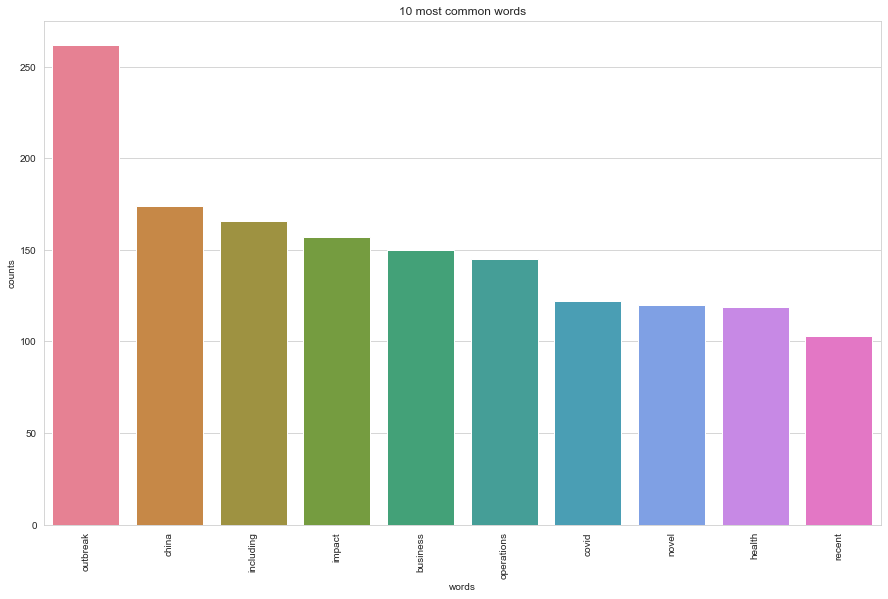

In [7]:
def tokenize(text):
    text = ''.join([ch for ch in text])
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]


sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
count_vectorizer = CountVectorizer(stop_words='english',lowercase=True,max_df=0.8, min_df=2)
# Fit and transform 
count_data = count_vectorizer.fit_transform(data['text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [9]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Priny the main 10 topics
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
number_topics = 4
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model (find appropriate interpretations)
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
outbreak business adversely operations impact recent affected covid financial results

Topic #1:
impact extent results uncertain future highly including outbreak developments depend

Topic #2:
china novel wuhan strain december covid outbreak reported surfaced travel

Topic #3:
including outbreak health natural events disasters economic public recent supply


In [11]:
#Display topic distribution
doc_topic_distrib = lda.transform(count_data)
data['topic_distribution'] = doc_topic_distrib.tolist()
df = pd.DataFrame(data=doc_topic_distrib)
df.insert(loc=0, column="SIC", value=data['sic'].values)
df['SIC']=df['SIC'].astype(int)
df=df.sort_values('SIC')
sectors = np.arange(1000,8900,100)
df['sector_groups']=pd.cut(df.SIC,sectors)
df['sectors']=(df.sector_groups!=df.sector_groups.shift()).cumsum()
df=df.groupby('sectors')[[0,1,2,3]].mean()

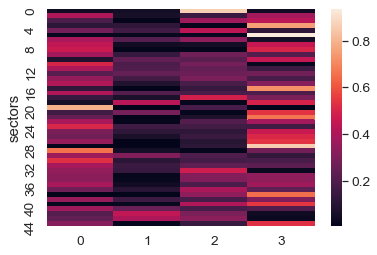

In [13]:
import seaborn as sb

data=data.topic_distribution.to_list()
heat_map = sb.heatmap(df)
figure = heat_map.get_figure()    
figure.savefig('heatmap.png', dpi=400)
df.to_csv('bottom_up.csv')

In [14]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
        

CPU times: user 616 ms, sys: 34.9 ms, total: 651 ms
Wall time: 1.22 s


In [15]:
pyLDAvis.enable_notebook()
pyLDAvis.display(LDAvis_prepared)